In [1]:
import os
from torchvision import transforms
import torchvision
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, TensorDataset 
class TensorDataset(Dataset):
    def __init__(self, *tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        im, targ = tuple(tensor[index] for tensor in self.tensors)
        if self.transform:
            real_transform = transforms.Compose([
                transforms.ToPILImage(),
                self.transform
            ])
            im = real_transform(im)
        return im, targ

    def __len__(self):
        return self.tensors[0].size(0)
    
def get_examples(train_data, train_labels, classes = [0, 1]):
    
    tasks_x = None
    tasks_y = None
    for idx in classes:
#         idxs.append(train_labels==idx)
        print(train_labels[train_labels == idx])
#         print("IDX:", idx)
        if(tasks_x == None):
            tasks_x = train_data[train_labels == idx].permute(0, 2, 3, 1)
            tasks_y = train_labels[train_labels == idx]
        else:
            tasks_x = torch.cat([tasks_x, train_data[train_labels == idx].permute(0, 2, 3, 1)])
            tasks_y = torch.cat([tasks_y, train_labels[train_labels == idx]])
            
    print("Concatenated", len(tasks_y), tasks_x.shape)
    return (tasks_x, tasks_y)

In [2]:
def load_cifar(ds_name="d_robust_CIFAR"):
    data_path = "/home/hikmat/Desktop/JWorkspace/CL/RCL/PY_CIFAR/datasets/release_datasets/{0}".format(ds_name)
    transform_train = transforms.Compose([
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
#         transforms.PILToTensor(),
    ])

    train_data = torch.cat(torch.load(os.path.join(data_path, f"CIFAR_ims")))
    train_labels = torch.cat(torch.load(os.path.join(data_path, f"CIFAR_lab")))
    
   
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, 
                                                transform=transform_test)
    
    return (train_data, train_labels), test_dataset

There are four datasets attached, corresponding to the four datasets discussed in section 3 of the paper:

robust_CIFAR: A dataset containing only the features relevant to a robust model, whereon standard (non-robust) training yields good robust accuracy

non_robust_CIFAR: A dataset containing only the features relevant to a natural model---the images do not look semantically related to the labels, but the dataset suffices for good test-set generalization

drand_CIFAR: A dataset consisting of adversarial examples on a natural model towards a random class and labeled as the random class. The only features that should be useful on this training set are non-robust features of the true dataset, so training on this gives good standard accuracy.

ddet_CIFAR: A dataset consisting of adversarial examples on a natural model towards a deterministic target class (y+1 mod C) and labeled as the target class. On the training set, both robust and non-robust features are useful, but robust features actually hurt generalization on the true dataset (instead they support generalization on an (x, y+1)) dataset.

In [3]:
CLASS = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# d_robust_CIFAR
# ddet_CIFAR
# drand_CIFAR
# d_non_robust_CIFAR
(train_data, train_labels), test_dataset = load_cifar(ds_name="d_robust_CIFAR")
print(type(train_data))

train_loader = torch.utils.data.DataLoader(TensorDataset(train_data, train_labels),
                                           batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

Files already downloaded and verified
<class 'torch.Tensor'>


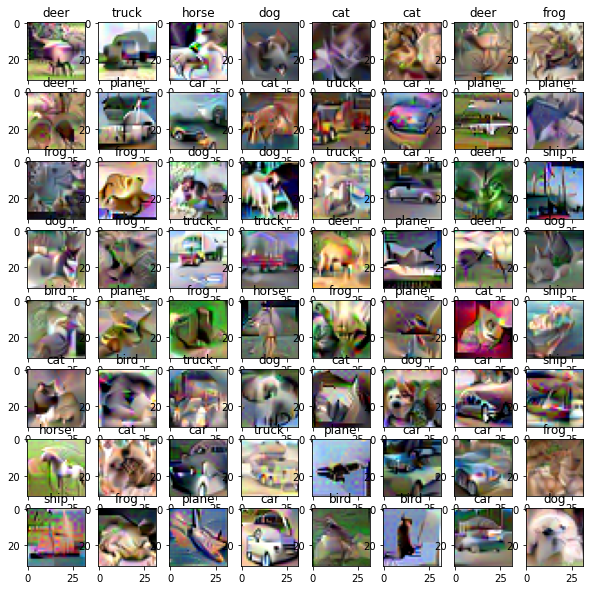

In [4]:
x, y = iter(train_loader).next()
fig = plt.figure(figsize=(10, 10))
rows = 8
columns = 8

for i in range(0, rows * columns):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(x[i].permute((1, 2, 0)))
    plt.title(CLASS[y[i]])

tensor([4, 4, 4,  ..., 4, 4, 4])
Concatenated 5000 torch.Size([5000, 32, 32, 3])


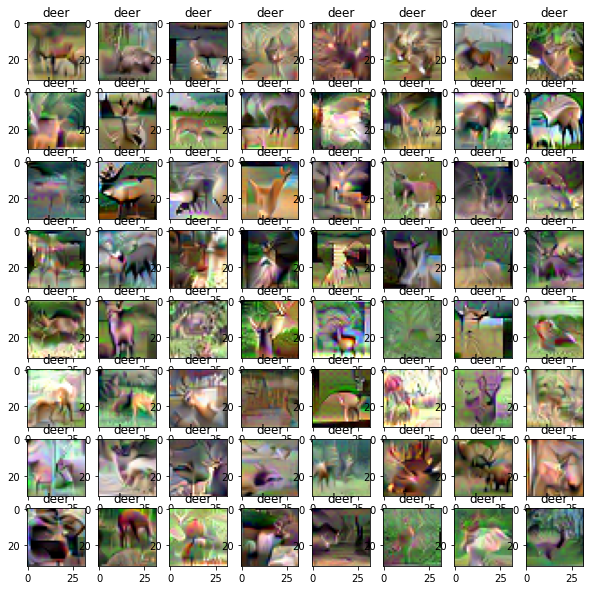

In [7]:
classes = [[4]]
task_x, task_y = get_examples(train_data, train_labels, classes=classes[0])
train_loader = torch.utils.data.DataLoader(TensorDataset(task_x, task_y),
                                           batch_size=64, shuffle=True, num_workers=4)
x, y = iter(train_loader).next()
# print(x.shape)
fig = plt.figure(figsize=(10, 10))
rows = 8
columns = 8
for i in range(0, rows * columns):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(x[i])
#     print("y[i]=", y[i].numpy())
    plt.title(CLASS[y[i]])

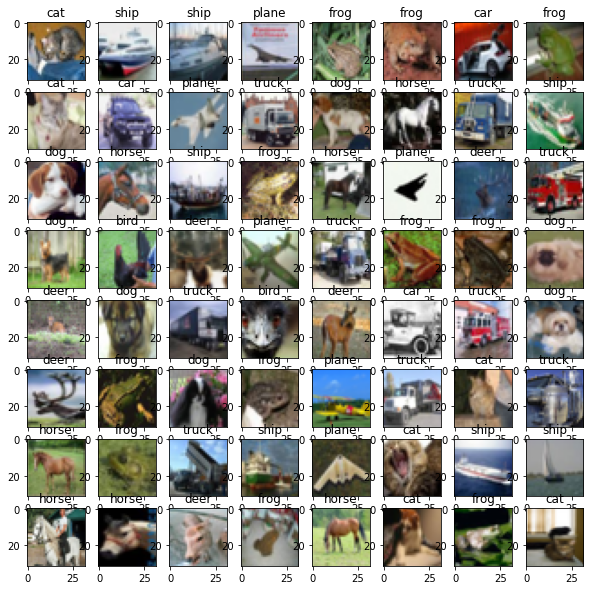

In [8]:
x, y = iter(test_loader).next()
fig = plt.figure(figsize=(10, 10))
rows = 8
columns = 8

for i in range(0, rows * columns):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(x[i].permute((1, 2, 0)))
    plt.title(CLASS[y[i]])